Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step
Epoch 1/10


/Users/kjingruz/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 1154s 6s/step - accuracy: 0.7611 - loss: 0.6999 - precision: 0.8394 - recall: 0.6397 - val_accuracy: 0.8589 - val_loss: 0.3354 - val_precision: 0.8617 - val_recall: 0.8505
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1125s 6s/step - accuracy: 0.9803 - loss: 0.0617 - precision: 0.9807 - recall: 0.9773 - val_accuracy: 0.9252 - val_loss: 0.2394 - val_precision: 0.9326 - val_recall: 0.9184
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1147s 6s/step - accuracy: 0.9893 - loss: 0.0315 - precision: 0.9903 - recall: 0.9890 - val_accuracy: 0.9756 - val_loss: 0.0779 - val_precision: 0.9763 - val_recall: 0.9741
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1146s 6s/step - accuracy: 0.9935 - loss: 0.0166 - precision: 0.9935 - recall: 0.9933 - val_accuracy: 0.9870 - val_loss: 0.0472 - val_precision: 0.9870 - val_recall: 0.9870
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1120s 6s/step - accuracy: 0.9944 - loss: 0.0141 - precision: 0.9947 - recall: 0.9944 - val_accuracy: 0.9947 - val_loss: 0.0

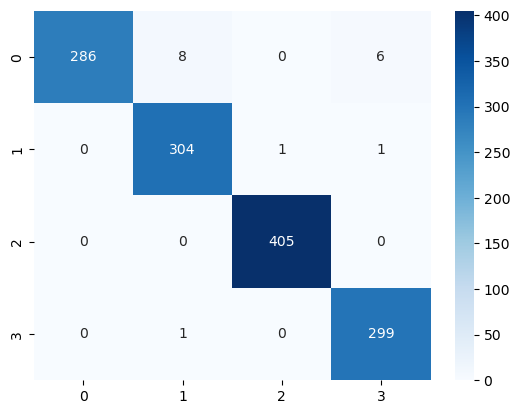

In [1]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Define the paths
train_path = './training'
test_path = './testing'

# Set the batch size and image size
batch_size = 32
img_size = (299, 299)

# Prepare ImageDataGenerators
_gen = ImageDataGenerator(rescale=1/255, brightness_range=(0.8, 1.2))
ts_gen = ImageDataGenerator(rescale=1/255)

tr_gen = _gen.flow_from_directory(train_path, target_size=img_size, batch_size=batch_size, class_mode='categorical')
ts_gen = ts_gen.flow_from_directory(test_path, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)

# Create the model using Xception as base
base_model = Xception(include_top=False, weights="imagenet", input_shape=img_size+(3,), pooling='max')

model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')  # 4 classes
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

# Train the model
history = model.fit(tr_gen, epochs=10, validation_data=ts_gen, shuffle=False)

# Evaluate the model
train_score = model.evaluate(tr_gen)
test_score = model.evaluate(ts_gen)

print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

# Predict and visualize the confusion matrix
predictions = model.predict(ts_gen)
predicted_classes = np.argmax(predictions, axis=-1)
true_classes = ts_gen.classes
cm = confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Classification report
print(classification_report(true_classes, predicted_classes))


In [4]:

# save with a '.keras' extension
model.save('MRI_model.keras')  # Saves in the TensorFlow Keras format (recommended)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_generator(img_path, mask_path, img_size, batch_size):
    # Image and Mask Data Generator
    data_gen_args = dict(rescale=1./255)
    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)

    # Provide the same seed and keyword arguments to the flow methods
    seed = 1
    image_generator = image_datagen.flow_from_directory(
        img_path,
        class_mode=None,
        target_size=img_size,
        batch_size=batch_size,
        seed=seed,
        color_mode='rgb')

    mask_generator = mask_datagen.flow_from_directory(
        mask_path,
        class_mode=None,
        target_size=img_size,
        batch_size=batch_size,
        seed=seed,
        color_mode='grayscale')  # Masks are typically in grayscale

    # Combine generators into one which yields image and masks
    train_generator = zip(image_generator, mask_generator)
    return train_generator

# Example usage
train_path = './training/images'
train_masks_path = './training/masks'
val_path = './validation/images'
val_masks_path = './validation/masks'
batch_size = 32
img_size = (299, 299)

train_gen = create_generator(train_path, train_masks_path, img_size, batch_size)
val_gen = create_generator(val_path, val_masks_path, img_size, batch_size)

# Now, use these generators in training
unet = unet_model(input_size=(299, 299, 3))
unet.fit(train_gen, epochs=10, validation_data=val_gen, steps_per_epoch=200, validation_steps=50)
unet.save('unet_segmentation_model.h5')


In [5]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def unet_model(input_size=(299, 299, 3)):
    inputs = Input(input_size)

    # Downsampling
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    # U-Net continues with additional downsampling and then upsampling layers...

    # Upsampling
    u6 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(p1)
    c6 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c6)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Assume seg_train_gen and seg_val_gen are set up to yield images and their corresponding masks
unet = unet_model()
unet.summary()

# Train the segmentation model
seg_history = unet.fit(seg_train_gen, epochs=10, validation_data=seg_val_gen, steps_per_epoch=200, validation_steps=50)
unet.save('unet_segmentation_model.keras')


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 299, 299, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 149, 149, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 298, 298, 16)   │         1,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 298, 298, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 298, 298, 1)    │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,825 (14.94 KB)

 Trainable params: 3,825 (14.94 KB)

 Non-trainable params: 0 (0.00 B)

NameError: name 'seg_train_gen' is not defined

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved models
classification_model = load_model('MRI_model.keras')
segmentation_model = load_model('unet_segmentation_model.h5')

# Example function to use both models
def classify_and_localize(image_path):
    import cv2
    from tensorflow.keras.preprocessing.image import img_to_array, load_img
    import matplotlib.pyplot as plt

    # Load and preprocess the image
    img = load_img(image_path, target_size=(299, 299))
    img_array = img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Classification
    class_prediction = classification_model.predict(img_array)
    class_label = np.argmax(class_prediction, axis=1)

    # Localization (Segmentation)
    seg_prediction = segmentation_model.predict(img_array)
    seg_prediction = (seg_prediction > 0.5).astype(np.uint8)  # Threshold the predictions

    # Plot results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.subplot(1, 2, 2)
    plt.imshow(seg_prediction[0, :, :, 0], cmap='gray')
    plt.title('Tumor Localization')
    plt.show()

    return class_label, seg_prediction

# Use the function with a new image
classify_and_localize('path_to_new_image.jpg')
